In [1]:
import os
import sys
import h5py
import json
import glob

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

mpl.style.use('seaborn-colorblind')
mpl.rc('font', size=15)
mpl.rc('figure', figsize=(8, 6))

## Split the dataset randomly by stars

In this section, we split the dataset into a train, validation, and test set randomly based on a given proportion. Because the dataset is split randomly, stars that belong to the same stream/cluster (same `parentid`) can belong to different dataset. This can potentially overfit, because the network can simple remember the properties of each stream. In the section below, we will split the dataset by stream, such that no stream in the training dataset would appear in the validation set.

In [3]:
# sim_dir = '/scratch/08317/tg876168/ananke_subsamples/m12i/lsr-0/'
sim_dir = '/scratch/08317/tg876168/ananke_subsamples/m12i/lsr-0/accreted_stellar_mass_all/'
sim_files = sorted(glob.glob(os.path.join(sim_dir, '*.hdf5')))
sim_files

['/scratch/08317/tg876168/ananke_subsamples/m12i/lsr-0/accreted_stellar_mass_all/lsr-0-rslice-0.m12i-res7100-subsamples.hdf5',
 '/scratch/08317/tg876168/ananke_subsamples/m12i/lsr-0/accreted_stellar_mass_all/lsr-0-rslice-1.m12i-res7100-subsamples.hdf5']

In [4]:
for i_file in range(len(sim_files)):
    with h5py.File(sim_files[i_file], 'r') as f:
        print(list(f.keys()))
        print(f['ra'].len())

['b', 'dec', 'feh', 'l', 'labels', 'parallax', 'parallax_over_error', 'parentid', 'pmdec', 'pmra', 'px_true', 'py_true', 'pz_true', 'ra', 'radial_velocity', 'source_id', 'vx_true', 'vy_true', 'vz_true']
411177
['b', 'dec', 'feh', 'l', 'labels', 'parallax', 'parallax_over_error', 'parentid', 'pmdec', 'pmra', 'px_true', 'py_true', 'pz_true', 'ra', 'radial_velocity', 'source_id', 'vx_true', 'vy_true', 'vz_true']
53


In [5]:
keys = ('l', 'b', 'parallax', 'pmra', 'pmdec', 'radial_velocity', 'feh', 'labels')

In [6]:
full_data = []
for sim_file in sim_files:
    with h5py.File(sim_file, 'r') as input_f:
        full_data.append(input_f['labels'][:])
full_data = np.concatenate(full_data)

In [11]:
full_data

array([[1.00000000e+00, 6.20264064e+08],
       [1.00000000e+00, 6.20264064e+08],
       [1.00000000e+00, 6.20264064e+08],
       ...,
       [1.00000000e+00, 2.76076256e+08],
       [1.00000000e+00, 1.98836448e+08],
       [0.00000000e+00, 8.07089950e+06]])

### Split data into train, validation, and test set

In [7]:
seed1 = 5642556
seed2 = 7196865

# n_max_file = 10000    # 1M samples per file
n_max_file = 10000000    # 10M samples per file

out_dir_base = '/scratch/08317/tg876168/dataset/m12i-lsr-0-stellar-mass'

In [8]:
for p in keys:
    full_data = []
    for sim_file in sim_files:
        with h5py.File(sim_file, 'r') as input_f:
            full_data.append(input_f[p][:])
    full_data = np.concatenate(full_data)
    
    # split dataset into training and validation
    train_data, val_data = train_test_split(
        full_data, test_size=0.2, random_state=seed1, shuffle=True)
    val_data, test_data = train_test_split(
        val_data, test_size=0.5, random_state=seed2, shuffle=True)
    
    # write each dataset
    for data, flag in zip(
        (train_data, val_data, test_data), ('train', 'val', 'test')):
        n_file = data.shape[0] // n_max_file + 1
        
        out_dir = os.path.join(out_dir_base, flag)     
        os.makedirs(out_dir, exist_ok=True)
        
        for i in range(n_file):
            file = os.path.join(out_dir, 'n{:02d}.hdf5'.format(i))
            with h5py.File(file, 'a') as output_f:
                # write sliced dataset to file
                start = i * n_max_file
                end = (i + 1) * n_max_file
                output_f.create_dataset(p, data=data[start: end])

In [9]:
# print out the counts and fraction of in situ and accreted stars for each flag
# we want to make sure each flag is drawn from the same distribution
properties = {}

for flag in ('train', 'val', 'test'):
    files = sorted(glob.glob(os.path.join(out_dir_base, f'{flag}/*')))

    labels = []
    for file in files:
        with h5py.File(file, 'r') as f:
            labels.append(f['labels'][:])
    labels = np.concatenate(labels)
    n_total = len(labels)

    print(flag)
    temp = {}
    for l in np.unique(labels):
        n = int(np.sum(labels==l))
        temp['n_{}'.format(l)] = n
        temp['f_{}'.format(l)] = n / n_total
        
        print('Number of class {:d} samples: {:d}'.format(l, n))
        print('Fraction of class {:d} samples: {:.4f}'.format(l, n / n_total))
    
    properties[flag] = temp
                
    print('---------------')


with open(os.path.join(out_dir_base, 'properties.json'), 'w') as f:
    json.dump(properties, f, indent=4)

train
Number of class 0 samples: 6828
Fraction of class 0 samples: 0.0279
Number of class 1 samples: 238264
Fraction of class 1 samples: 0.9721
---------------
val
Number of class 0 samples: 829
Fraction of class 0 samples: 0.0271
Number of class 1 samples: 29808
Fraction of class 1 samples: 0.9729
---------------
test
Number of class 0 samples: 852
Fraction of class 0 samples: 0.0278
Number of class 1 samples: 29785
Fraction of class 1 samples: 0.9722
---------------


### Preprocessing dict
During training, we will scale the training data such that for each feature, the mean and standard deviation is 0 and 1, respectively. We want to compute these values prior to training and store it somewhere such that it can be read easily (and quickly).

In [12]:
train_files = sorted(glob.glob(os.path.join(out_dir_base, 'train/*')))

preprocess_dict = {}

# loop over all keys and compute mean and stdv
for p in keys:
    if p == 'labels':
        continue
    data = []
    for file in train_files:
        with h5py.File(file, 'r') as f:
            data.append(f[p][:])
    data = np.concatenate(data)
    
    mean = np.nanmean(data)
    stdv = np.nanstd(data)
    
    print(f'Keys: {p}')
    print('Mean: {:.4e}'.format(mean))
    print('stdv: {:.4e}'.format(stdv))
    print('----------------')
    
    preprocess_dict[p] = {
        'mean': float(mean), 
        'stdv': float(stdv),
    }
    
with open(os.path.join(out_dir_base, 'preprocess.json'), 'w') as f:
    json.dump(preprocess_dict, f, indent=4)

Keys: l
Mean: -1.5467e+00
stdv: 9.8288e+01
----------------
Keys: b
Mean: 3.0008e+00
stdv: 3.7832e+01
----------------
Keys: parallax
Mean: 1.2507e+00
stdv: 1.0972e+00
----------------
Keys: pmra
Mean: -6.7181e+00
stdv: 7.2136e+01
----------------
Keys: pmdec
Mean: -3.5606e+01
stdv: 8.2909e+01
----------------
Keys: radial_velocity
Mean: -9.9484e+00
stdv: 2.3880e+02
----------------
Keys: feh
Mean: -1.5453e+00
stdv: 5.0982e-01
----------------


### Radial velocity dataset
For many stars, we do not have access to radial velocity information. We can apply a non-NaN cut on the radial velocity of our original dataset, but it is faster to create a second dataset with only stars that have radial velocity information (though it would take more disk space).

In [13]:
out_dir_base_rv = out_dir_base + '-rv'
out_dir_base_rv

'/scratch/08317/tg876168/dataset/m12i-lsr-0-stellar-mass-rv'

In [14]:
# read in input files from the original dataset and copy them selectively
# print out the counts and fraction of in situ and accreted stars for each flag
# we want to make sure each flag is drawn from the same distribution
properties = {}
preprocess_dict = {}

for flag in ('train', 'val', 'test'):
    
    # create a new dataset directory
    out_dir = os.path.join(out_dir_base_rv, flag)
    os.makedirs(out_dir, exist_ok=True)
    
    # iterate over all dataset files
    in_files = sorted(glob.glob(os.path.join(out_dir_base, f'{flag}/*')))
    for i, in_file in enumerate(in_files):
        
        out_file = os.path.join(out_dir, 'n{:02d}.hdf5'.format(i))
        
        with h5py.File(in_file, 'r') as input_f:
            with h5py.File(out_file, 'w') as output_f:

                # only consider stars with radial velocity information
                rv = input_f['radial_velocity'][:]
                rv_isnotnan = ~np.isnan(rv)
            
                for p in input_f.keys():
                    output_f.create_dataset(p, data=input_f[p][rv_isnotnan])
    
    # recompute the number of in situ and accreted samples in the new dataset
    labels = []
    out_files = sorted(glob.glob(os.path.join(out_dir_base_rv, f'{flag}/*')))    
    for file in out_files:
        with h5py.File(file, 'r') as f:
            labels.append(f['labels'][:])
    labels = np.concatenate(labels)
    n_total = len(labels)

    print(flag)
    temp = {}
    for l in np.unique(labels):
        n = int(np.sum(labels==l))
        temp['n_{}'.format(l)] = n
        temp['f_{}'.format(l)] = n / n_total
        
        print('Number of class {:d} samples: {:d}'.format(l, n))
        print('Fraction of class {:d} samples: {:.4f}'.format(l, n / n_total))
    
    properties[flag] = temp
                
    print('---------------')

    # if training data, we will also recompute the mean
    # and standard deviation after the radial-velocity cut
    if flag == 'train':
        for p in keys:
            if p == 'labels':
                continue
            data = []
            for file in out_files:
                with h5py.File(file, 'r') as f:
                    data.append(f[p][:])
            data = np.concatenate(data)
            mean = np.nanmean(data)
            stdv = np.nanstd(data)

            print(f'Keys: {p}')
            print('Mean: {:.4e}'.format(mean))
            print('stdv: {:.4e}'.format(stdv))
            print('----------------')

            preprocess_dict[p] = {
                'mean': float(mean), 
                'stdv': float(stdv),
            }

            
# write dataset properties and preprocessing dict to JSON files in new directory
with open(os.path.join(out_dir_base_rv, 'properties.json'), 'w') as f:
    json.dump(properties, f, indent=4)
with open(os.path.join(out_dir_base_rv, 'preprocess.json'), 'w') as f:
    json.dump(preprocess_dict, f, indent=4)

train
Number of class 0 samples: 804
Fraction of class 0 samples: 0.0238
Number of class 1 samples: 32949
Fraction of class 1 samples: 0.9762
---------------
Keys: l
Mean: -1.8911e+00
stdv: 9.8613e+01
----------------
Keys: b
Mean: 3.1147e+00
stdv: 3.7433e+01
----------------
Keys: parallax
Mean: 1.4671e+00
stdv: 1.8777e+00
----------------
Keys: pmra
Mean: -7.2363e+00
stdv: 1.0059e+02
----------------
Keys: pmdec
Mean: -4.0649e+01
stdv: 1.2383e+02
----------------
Keys: radial_velocity
Mean: -9.9484e+00
stdv: 2.3880e+02
----------------
Keys: feh
Mean: -1.4937e+00
stdv: 4.9026e-01
----------------
val
Number of class 0 samples: 107
Fraction of class 0 samples: 0.0249
Number of class 1 samples: 4195
Fraction of class 1 samples: 0.9751
---------------
test
Number of class 0 samples: 102
Fraction of class 0 samples: 0.0243
Number of class 1 samples: 4092
Fraction of class 1 samples: 0.9757
---------------


## Split the dataset randomly by particles

In this section, instead of splitting the dataset randomly by stars, we split it by particles. This helps prevent the network from simply remembering the properties of each merger. It's worth noting that one merger can contain multiple particles, so this method is not completely fool-proof.

In [3]:
# sim_dir = '/scratch/08317/tg876168/ananke_subsamples/m12i/lsr-0/'
sim_dir = '/scratch/08317/tg876168/ananke_subsamples/m12i/lsr-0/accreted_stellar_mass_all/'
sim_files = sorted(glob.glob(os.path.join(sim_dir, '*.hdf5')))
sim_files

['/scratch/08317/tg876168/ananke_subsamples/m12i/lsr-0/accreted_stellar_mass_all/lsr-0-rslice-0.m12i-res7100-subsamples.hdf5',
 '/scratch/08317/tg876168/ananke_subsamples/m12i/lsr-0/accreted_stellar_mass_all/lsr-0-rslice-1.m12i-res7100-subsamples.hdf5']

In [4]:
for i_file in range(len(sim_files)):
    with h5py.File(sim_files[i_file], 'r') as f:
        print(list(f.keys()))
        print(f['ra'].len())

['b', 'dec', 'feh', 'l', 'labels', 'parallax', 'parallax_over_error', 'parentid', 'pmdec', 'pmra', 'px_true', 'py_true', 'pz_true', 'ra', 'radial_velocity', 'source_id', 'vx_true', 'vy_true', 'vz_true']
411177
['b', 'dec', 'feh', 'l', 'labels', 'parallax', 'parallax_over_error', 'parentid', 'pmdec', 'pmra', 'px_true', 'py_true', 'pz_true', 'ra', 'radial_velocity', 'source_id', 'vx_true', 'vy_true', 'vz_true']
53


In [5]:
keys = ('l', 'b', 'parallax', 'pmra', 'pmdec', 'radial_velocity', 'feh', 'labels')

In [6]:
seed1 = 5642556
seed2 = 7196865

# n_max_file = 10000    # 1M samples per file
n_max_file = 10000000    # 10M samples per file

out_dir_base = '/scratch/08317/tg876168/dataset/accreted_stellar_mass_all/dset-particles'

In [9]:
# from the simulation files, read in the parentid of each star
# the parentid determines the stream/cluster the star originally belong too in FIRE
parentid = []
labels = []
for sim_file in sim_files:
    with h5py.File(sim_file, 'r') as input_f:
        parentid.append(input_f['parentid'][:])
        labels.append(input_f['labels'][:])
parentid = np.concatenate(parentid)
labels = np.concatenate(labels)

# also read in the mass of each parentid
with h5py.File('/scratch/08317/tg876168/labels_mapping/accreted_stellar_mass_all.hdf5', 'r') as f:
    mass = 10**f['log10_halo_stellar_mass'][:]
    particle_id = f['id_stars'][:]
    merger_count = f['merger_count'][:]
    
    sort = np.argsort(particle_id)
    particle_id = particle_id[sort]
    mass = mass[sort]
    
    thres = f.attrs['threshold']

In [11]:
# get unique parent id
unique, counts = np.unique(parentid, return_counts=True)

# shuffle 
shuffle = np.random.permutation(len(unique))
unique = unique[shuffle]
counts = counts[shuffle]
cum_counts = np.cumsum(counts)

# calculate the number of stars in each dataset and split
N_total = len(labels)
N_val = int(N_total * 0.1)
N_test = int(N_total * 0.1)
N_train = N_total - N_val - N_test

# partition parentid into train, val, test dataset 
part = []
part.append(np.where(cum_counts > N_train)[0][0])
part.append(np.where(cum_counts > N_train + N_val)[0][0])
part_parentid = {
    'train': unique[: part[0]],
    'val': unique[part[0]: part[1]],
    'test': unique[part[1]:]
}

# get the index of each star in each dataset
train_idx = np.array([i for i in range(len(parentid)) 
                      if parentid[i] in part_parentid['train']])
val_idx = np.array([i for i in range(len(parentid)) 
                    if parentid[i] in part_parentid['val']])
test_idx = np.array([i for i in range(len(parentid)) 
                     if parentid[i] in part_parentid['test']])

First, we want to check the mass distribution of the particles for each dataset

In [14]:
# we want to check the mass distribution of the particle for each set
train_mass = np.array([mass[i] for i in range(len(particle_id)) 
                       if particle_id[i] in part_parentid['train']])
val_mass = np.array([mass[i] for i in range(len(particle_id)) 
                       if particle_id[i] in part_parentid['val']])
test_mass = np.array([mass[i] for i in range(len(particle_id)) 
                       if particle_id[i] in part_parentid['test']])

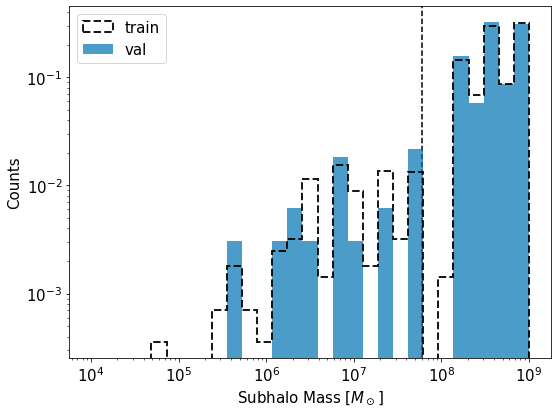

In [15]:
fig, ax = plt.subplots(1)

bins = 10**np.linspace(4, 9, 30)

# train
counts, bins = np.histogram(train_mass, bins)
counts = counts / np.sum(counts)  # normalize by the total number (not the area)
ax.hist(bins[:-1], bins, weights=counts, histtype='step', 
        lw=2, zorder=10, color='k', alpha=0.9, ls='--', label='train')

# val
counts, bins = np.histogram(val_mass, bins)
counts = counts / np.sum(counts)  # normalize by the total number (not the area)
ax.hist(bins[:-1], bins, weights=counts,
        lw=2, zorder=8, alpha=0.7, ls='--', label='val')

# # test
# counts, bins = np.histogram(test_mass, bins)
# counts = counts / np.sum(counts)  # normalize by the total number (not the area)
# ax.hist(bins[:-1], bins, weights=counts, histtype='step', 
#         lw=2, zorder=9, color='r', label='test')

# format axis and figure
ax.axvline(thres, color='k', ls='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Subhalo Mass [$M_\odot$]')
ax.set_ylabel('Counts')

ax.legend()

fig.tight_layout()

Because everything seems right, we begin split the dataset using the split above.

In [16]:
for p in keys:
    full_data = []
    for sim_file in sim_files:
        with h5py.File(sim_file, 'r') as input_f:
            full_data.append(input_f[p][:])
    full_data = np.concatenate(full_data)
    
    # quick fix for label
    # TODO: find a perma fix
    if p == 'labels':
        full_data = full_data[:, 0]

    
    # split the dataset into training, validation, and test set    
    train_data = full_data[train_idx]
    val_data = full_data[val_idx]
    test_data = full_data[test_idx]
    
    # write each dataset
    for data, flag in zip(
        (train_data, val_data, test_data), ('train', 'val', 'test')):
        n_file = data.shape[0] // n_max_file + 1
        
        out_dir = os.path.join(out_dir_base, flag)     
        os.makedirs(out_dir, exist_ok=True)
        
        for i in range(n_file):
            file = os.path.join(out_dir, 'n{:02d}.hdf5'.format(i))
            with h5py.File(file, 'a') as output_f:
                # write sliced dataset to file
                start = i * n_max_file
                end = (i + 1) * n_max_file
                output_f.create_dataset(p, data=data[start: end])

In [17]:
# print out the counts and fraction of in situ and accreted stars for each flag
# we want to make sure each flag is drawn from the same distribution
properties = {}

for flag in ('train', 'val', 'test'):
    files = sorted(glob.glob(os.path.join(out_dir_base, f'{flag}/*')))

    labels = []
    for file in files:
        with h5py.File(file, 'r') as f:
            labels.append(f['labels'][:])
    labels = np.concatenate(labels)
    n_total = len(labels)

    print(flag)
    temp = {}
    for l in np.unique(labels):
        l = int(l)
        n = int(np.sum(labels==l))
        temp['n_{}'.format(l)] = n
        temp['f_{}'.format(l)] = n / n_total
        
        print('Number of class {:d} samples: {:d}'.format(l, n))
        print('Fraction of class {:d} samples: {:.4f}'.format(l, n / n_total))
    
    properties[flag] = temp
                
    print('---------------')


with open(os.path.join(out_dir_base, 'properties.json'), 'w') as f:
    json.dump(properties, f, indent=4)

train
Number of class 0 samples: 15855
Fraction of class 0 samples: 0.0482
Number of class 1 samples: 313059
Fraction of class 1 samples: 0.9518
---------------
val
Number of class 0 samples: 1485
Fraction of class 0 samples: 0.0361
Number of class 1 samples: 39602
Fraction of class 1 samples: 0.9639
---------------
test
Number of class 0 samples: 2633
Fraction of class 0 samples: 0.0639
Number of class 1 samples: 38596
Fraction of class 1 samples: 0.9361
---------------


In [18]:
train_files = sorted(glob.glob(os.path.join(out_dir_base, 'train/*')))

preprocess_dict = {}

# loop over all keys and compute mean and stdv
for p in keys:
    if p == 'labels':
        continue
    data = []
    for file in train_files:
        with h5py.File(file, 'r') as f:
            data.append(f[p][:])
    data = np.concatenate(data)
    
    mean = np.nanmean(data)
    stdv = np.nanstd(data)
    
    print(f'Keys: {p}')
    print('Mean: {:.4e}'.format(mean))
    print('stdv: {:.4e}'.format(stdv))
    print('----------------')
    
    preprocess_dict[p] = {
        'mean': float(mean), 
        'stdv': float(stdv),
    }
    
with open(os.path.join(out_dir_base, 'preprocess.json'), 'w') as f:
    json.dump(preprocess_dict, f, indent=4)

Keys: l
Mean: -2.0830e+00
stdv: 9.9275e+01
----------------
Keys: b
Mean: 2.1444e+00
stdv: 3.8874e+01
----------------
Keys: parallax
Mean: 1.1575e+00
stdv: 9.7349e-01
----------------
Keys: pmra
Mean: -4.1569e+00
stdv: 6.3547e+01
----------------
Keys: pmdec
Mean: -3.4238e+01
stdv: 7.0146e+01
----------------
Keys: radial_velocity
Mean: -1.8132e+00
stdv: 2.2436e+02
----------------
Keys: feh
Mean: -1.6138e+00
stdv: 5.2611e-01
----------------


### Radial velocity dataset

In [19]:
out_dir_base_rv = out_dir_base + '-rv'
out_dir_base_rv

'/scratch/08317/tg876168/dataset/accreted_stellar_mass_all/dset-particles-rv'

In [20]:
# read in input files from the original dataset and copy them selectively
# print out the counts and fraction of in situ and accreted stars for each flag
# we want to make sure each flag is drawn from the same distribution
properties = {}
preprocess_dict = {}

for flag in ('train', 'val', 'test'):
    
    # create a new dataset directory
    out_dir = os.path.join(out_dir_base_rv, flag)
    os.makedirs(out_dir, exist_ok=True)
    
    # iterate over all dataset files
    in_files = sorted(glob.glob(os.path.join(out_dir_base, f'{flag}/*')))
    for i, in_file in enumerate(in_files):
        
        out_file = os.path.join(out_dir, 'n{:02d}.hdf5'.format(i))
        
        with h5py.File(in_file, 'r') as input_f:
            with h5py.File(out_file, 'w') as output_f:

                # only consider stars with radial velocity information
                rv = input_f['radial_velocity'][:]
                rv_isnotnan = ~np.isnan(rv)
            
                for p in input_f.keys():
                    output_f.create_dataset(p, data=input_f[p][rv_isnotnan])
    
    # recompute the number of in situ and accreted samples in the new dataset
    labels = []
    out_files = sorted(glob.glob(os.path.join(out_dir_base_rv, f'{flag}/*')))    
    for file in out_files:
        with h5py.File(file, 'r') as f:
            labels.append(f['labels'][:])
    labels = np.concatenate(labels)
    n_total = len(labels)

    print(flag)
    temp = {}
    for l in np.unique(labels):
        l = int(l)
        n = int(np.sum(labels==l))
        temp['n_{}'.format(l)] = n
        temp['f_{}'.format(l)] = n / n_total
        
        print('Number of class {:d} samples: {:d}'.format(l, n))
        print('Fraction of class {:d} samples: {:.4f}'.format(l, n / n_total))
    
    properties[flag] = temp
                
    print('---------------')

    # if training data, we will also recompute the mean
    # and standard deviation after the radial-velocity cut
    if flag == 'train':
        for p in keys:
            if p == 'labels':
                continue
            data = []
            for file in out_files:
                with h5py.File(file, 'r') as f:
                    data.append(f[p][:])
            data = np.concatenate(data)
            mean = np.nanmean(data)
            stdv = np.nanstd(data)

            print(f'Keys: {p}')
            print('Mean: {:.4e}'.format(mean))
            print('stdv: {:.4e}'.format(stdv))
            print('----------------')

            preprocess_dict[p] = {
                'mean': float(mean), 
                'stdv': float(stdv),
            }

            
# write dataset properties and preprocessing dict to JSON files in new directory
with open(os.path.join(out_dir_base_rv, 'properties.json'), 'w') as f:
    json.dump(properties, f, indent=4)
with open(os.path.join(out_dir_base_rv, 'preprocess.json'), 'w') as f:
    json.dump(preprocess_dict, f, indent=4)

train
Number of class 0 samples: 1970
Fraction of class 0 samples: 0.0435
Number of class 1 samples: 43325
Fraction of class 1 samples: 0.9565
---------------
Keys: l
Mean: -2.1842e+00
stdv: 9.9242e+01
----------------
Keys: b
Mean: 2.2438e+00
stdv: 3.8612e+01
----------------
Keys: parallax
Mean: 1.2926e+00
stdv: 1.5820e+00
----------------
Keys: pmra
Mean: -4.0748e+00
stdv: 8.6690e+01
----------------
Keys: pmdec
Mean: -3.8248e+01
stdv: 9.6884e+01
----------------
Keys: radial_velocity
Mean: -1.8132e+00
stdv: 2.2436e+02
----------------
Keys: feh
Mean: -1.5666e+00
stdv: 5.1834e-01
----------------
val
Number of class 0 samples: 176
Fraction of class 0 samples: 0.0292
Number of class 1 samples: 5848
Fraction of class 1 samples: 0.9708
---------------
test
Number of class 0 samples: 325
Fraction of class 0 samples: 0.0553
Number of class 1 samples: 5555
Fraction of class 1 samples: 0.9447
---------------
